## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph

# importing for my project
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import pickle

External Losses (Chamfer-EMD) were not loaded.
External Losses (Chamfer-EMD) cannot be loaded. Please install them first.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [3]:
top_out_dir = './latent_3d_points/data/'                      
top_in_dir = './latent_3d_points/data/shape_net_core_uniform_samples_2048/'

experiment_name = 'single_class_ae'
n_pc_points = 2048                              # Number of points per model.
bneck_size = 128                                # Bottleneck-AE size
ae_loss = 'emd'                             # Loss to optimize: 'emd' or 'chamfer'
class_name = 'cap'#raw_input('Give me the class name (e.g. "chair"): ').lower()

Load Point-Clouds

In [4]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

56 pclouds were loaded. They belong in 1 shape-classes.


Load default training parameters (some of which are listed here). For more details please use print, etc.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of this many epochs)
    'saver_step': 10       (# how many epochs to save neural-network)

In [5]:
train_dir = create_dir(osp.join(top_out_dir, experiment_name))
train_params = default_train_params()
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)

In [6]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5              # How often to evaluate/print out loss on held_out data (if any).
conf.save(osp.join(train_dir, 'configuration'))

dict_values([[2048, 3], False, 'emd', <function decoder_with_fc_only at 0x1193047b8>, <function encoder_with_convs_and_symmetry at 0x105d7a598>, {'n_filters': [32, 64, 64, 128, 32], 'filter_sizes': [1], 'strides': [1], 'b_norm': True, 'verbose': True}, {'layer_sizes': [256, 256, 6144], 'b_norm': False, 'b_norm_finish': False, 'verbose': True}, 50, 0.0005, 1, 10, './latent_3d_points/data/single_class_ae', None, False, None, 2, False, 1.0, None, [2048, 3], None, 'single_class_ae', 5])
<class 'dict_values'>


Build AE Model.

In [7]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

Building Encoder
encoder_conv_layer_0 conv params =  128
bnorm params =  64
Tensor("single_class_ae_2/Relu:0", shape=(?, 2048, 32), dtype=float32)
output size: 65536 

encoder_conv_layer_1 conv params =  2112
bnorm params =  128
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_2 conv params =  4160
bnorm params =  128
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_3 conv params =  8320
bnorm params =  256
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_4 conv params =  4128
bnorm params =  64
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 2048, 32), dtype=float32)
output size: 65536 

Tensor("single_class_ae_2/Max:0", shape=(?, 32), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  8448
Tensor("single_class_ae_2/Relu_5:0", shape=(?, 256), dtype=float32)
output size: 256 

decoder_fc

Train the AE (save output to train_stats.txt) 

In [8]:
ae.restore_model('./latent_3d_points/data/single_class_ae' , 1000)

INFO:tensorflow:Restoring parameters from ./latent_3d_points/data/single_class_ae/models.ckpt-1000


In [9]:
def displaySP(pntClouds):
    fig = plt.figure(num=None, figsize=(12, 10),
                     dpi=80, facecolor='w',
                     edgecolor='k')
    for i in range (pntClouds.shape[0]):
        pntCloud = pntClouds[i,:,:]
        col = int (i % 3)
        row = int(col *3)
        curAxis = fig.add_subplot(4,3,i+1, projection='3d')
        pntX = [pnt[0] for pnt in pntCloud ]
        pntY = [pnt[1] for pnt in pntCloud ]
        pntZ = [pnt[2] for pnt in pntCloud ]
        col = random.sample(range(0, 100), 3)
        #col = (50,50,50, .1)
        curAxis.scatter(pntX, pntY, pntZ, color=[float(col[0])/100.0, 
                                                 float(col[1])/100.0, 
                                                 float(col[2])/100.0], 
                                                marker='o')

In [10]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)
reconstructions = ae.reconstruct(feed_pc)
latent_codes = ae.transform(feed_pc)

def displaySP(pntCloud):
    # Display Super Point Cloud
    # INPUT: Super Point Point Cloud Nspx4 [(x1,y1,z1,[]),(x2,y2,z2,[]),...(xn,yn,zn,[])]
    # OUTPUT: Display
    fig = plt.figure()
    curAxis = fig.add_subplot(111, projection='3d')
    pntX = [pnt[0] for pnt in pntCloud ]
    pntY = [pnt[1] for pnt in pntCloud ]
    pntZ = [pnt[2] for pnt in pntCloud ]
    col = random.sample(range(1, 100), 3)
    curAxis.scatter(pntX, pntY, pntZ, color=[float(col[0])/100.0, float(col[1])/100.0, float(col[2])/100.0], marker='o')

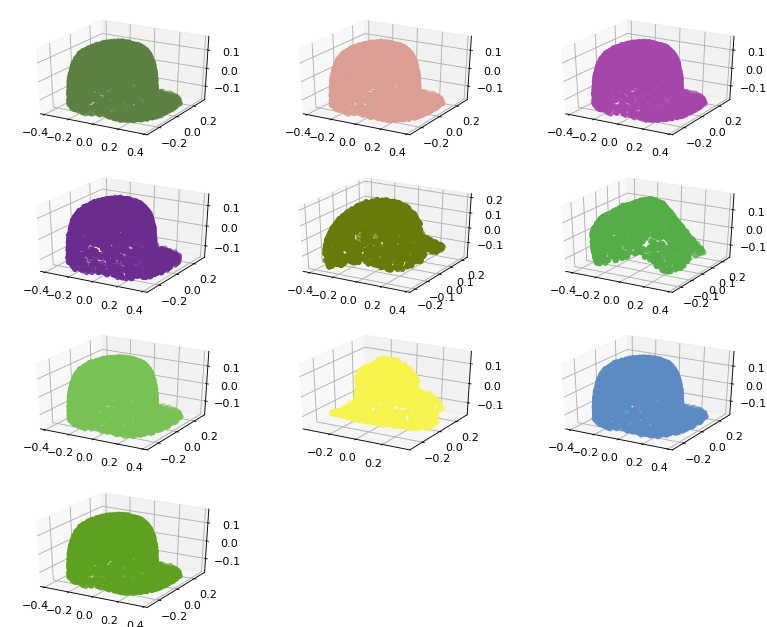

In [11]:
recon,_ = (reconstructions) 
displaySP(recon)

In [12]:
maxData = (np.amax(latent_codes, axis = 0))
minData = (np.amin(latent_codes, axis = 0))

rangeData = maxData - minData
newSamples = []
for i in range(10):
    newRange = rangeData * random.random()
    newSamples.append(minData + newRange)
    
newSamples = np.array(newSamples)
print (newSamples.shape)


(10, 32)


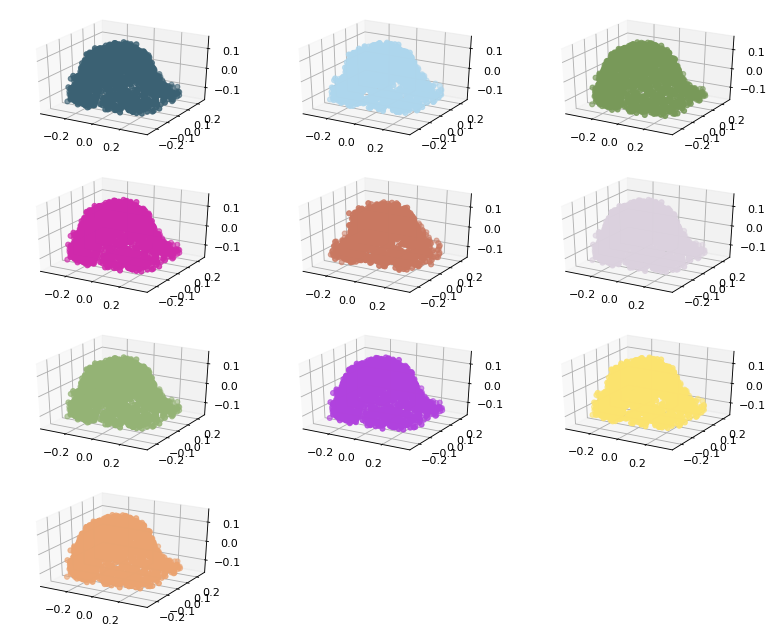

In [13]:
out = ae.decode(newSamples)
displaySP(out)

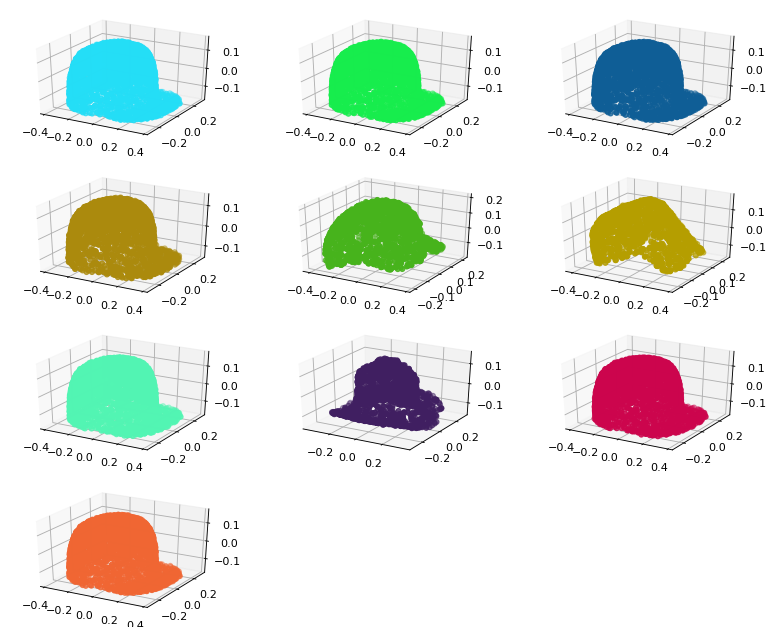

In [14]:
out = ae.decode(latent_codes)
displaySP(out)


In [15]:
with open("range.p", 'wb') as f: 
    pickle.dump(rangeData.tolist(), f, protocol = 2)
    
with open("max.p", 'wb') as f: 
    pickle.dump(maxData.tolist(), f, protocol = 2)
    
with open("min.p", 'wb') as f: 
    pickle.dump(minData.tolist(), f, protocol = 2)
    
favorite_color = pickle.load( open( "feature_space.p", "rb" ) )

In [16]:
with open("sample_00.p", 'wb') as f: 
    pickle.dump(recon[0].tolist(), f, protocol = 2)
with open("sample_01.p", 'wb') as f: 
    pickle.dump(recon[5].tolist(), f, protocol = 2)

In [17]:
f = open('dataSet00.txt','w')
f.write(recon[5].tolist())
f.close()

TypeError: write() argument must be str, not list

In [18]:
np.savetxt('test.txt', recon[5], delimiter=',')

In [19]:
recon_ = recon[:,:,:]

recon_.shape

(10, 2048, 3)

In [20]:
import codecs, json

In [21]:
for i in range(10):
    file_path = "test{}.json".format(i) ## your path variable
    json.dump(recon[i].tolist(), codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format


file_path = "testAll.json".format(i) ## your path variable
json.dump(recon_.tolist(), codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format




In [22]:
for i in range (10):
    name = "latentSample_0{}.p".format(i)
    with open(name, 'wb') as f: 
        pickle.dump(latent_codes[i].tolist(), f, protocol = 2)


In [23]:
favorite_color = pickle.load( open( "latentSample_00.p", "rb" ) )

In [24]:
favorite_color


[1.8067131042480469,
 2.008908271789551,
 2.4043800830841064,
 3.4980223178863525,
 2.64611554145813,
 2.532224655151367,
 2.0403714179992676,
 1.5315485000610352,
 1.2638022899627686,
 2.490736246109009,
 3.9109175205230713,
 3.1585793495178223,
 2.4434814453125,
 1.863362193107605,
 1.9519952535629272,
 2.359145164489746,
 2.528007745742798,
 1.8710289001464844,
 2.638212203979492,
 1.3970036506652832,
 2.997195243835449,
 2.093961715698242,
 3.694338798522949,
 2.1731317043304443,
 1.8843371868133545,
 3.6705050468444824,
 1.7791857719421387,
 1.926202654838562,
 1.9409863948822021,
 2.0006444454193115,
 2.785903215408325,
 1.0491503477096558]